# Online Shoppers Intention (Data set from UCI machine learning repository)
- Build a classification model to predict shoppers intention 
- Steps
    - EDA: Explore the data set
    - Feature Engineering
    - Model Building
    - Model Validation

In [1]:
## import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support,roc_curve,roc_auc_score,roc_curve,precision_recall_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
import mlflow
plt.style.use('fivethirtyeight')


## Data Set Information:

- The dataset consists of feature vectors belonging to 12,330 sessions.
- Each session belongs to a different user 
- There are 10 numerical features and 8 categorical features
- Revenue Column (Bool Type ). This feature represents if the user completed the purchase or not. ```This is what we we will try to predict ```

In [2]:
df_shopping_data = pd.read_csv('online_shoppers_intention.csv')
print('Number of rows in date set',df_shopping_data.shape)
display(df_shopping_data.head(n=2))
display(df_shopping_data.dtypes)

Number of rows in date set (12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False


Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

## EDA

### No Null Values across columns
- No imputation or dropping of data needed

In [3]:
## EDA
print('Number of null values across columns \n',df_shopping_data.isna().sum())

Number of null values across columns 
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


### Number of Buyers who completed a purchase VS not complete
- This is a highly imbalance set
- In general this would make sense as percentage of buyers who complete a transaction woule be less.

In [4]:
df_shopping_data.Revenue.value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

### Normalize the features 
- Administrative :Number of pages of this type (administrative) that the user visited.
- Administrative_Duration: This is the amount of time spent in this category of pages.
- We normalize it using Administrative_Duration/Administrative
- Do similar transformation for Informational and ProductRelated features
- The Boxplots by Revenue indicates that these features would be helpful for model prediction

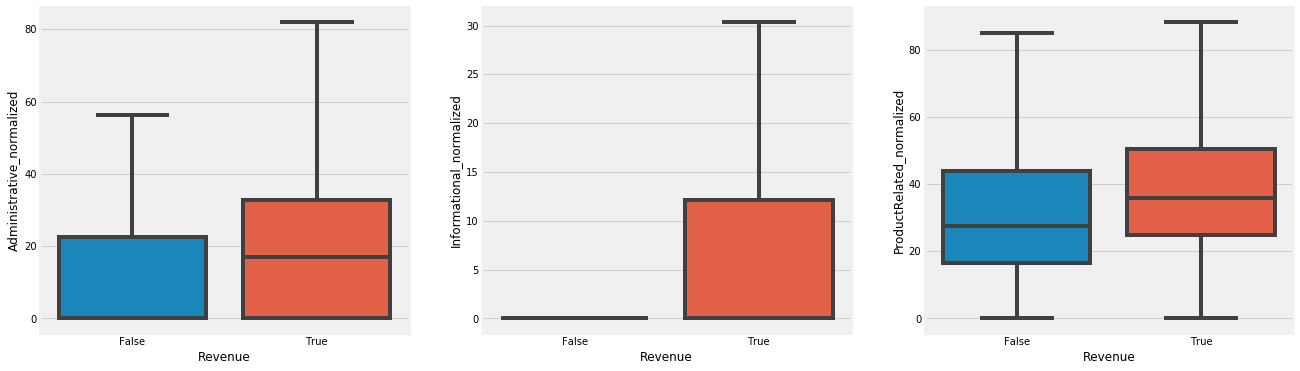

In [5]:
df_shopping_data['Administrative_normalized'] = df_shopping_data['Administrative_Duration']/(df_shopping_data['Administrative'])
df_shopping_data['Administrative_normalized'].fillna(0,inplace=True)

df_shopping_data['Informational_normalized'] = df_shopping_data['Informational_Duration']/(df_shopping_data['Informational'])
df_shopping_data['Informational_normalized'].fillna(0,inplace=True)


df_shopping_data['ProductRelated_normalized'] = df_shopping_data['ProductRelated_Duration']/(df_shopping_data['ProductRelated'])
df_shopping_data['ProductRelated_normalized'].fillna(0,inplace=True)

fig, axs = plt.subplots(1,3,figsize=(20,6))

sns.boxplot(y= 'Administrative_normalized',x= 'Revenue',ax=axs[0],data=df_shopping_data,showfliers=False)
sns.boxplot(y= 'Informational_normalized',x= 'Revenue',ax=axs[1],data=df_shopping_data,showfliers=False)
sns.boxplot(y= 'ProductRelated_normalized',x= 'Revenue',ax=axs[2],data=df_shopping_data,showfliers=False)

### Explore the standard digital metrics
- BounceRates: The percentage of visitors who enter the website through that page and exit without triggering any additional tasks.
- ExitRates: The percentage of pageviews on the website that end at that specific page.
- PageValues: Average value of a page
- Drop the PageValues feature (Outliers present)

<Figure size 432x288 with 0 Axes>

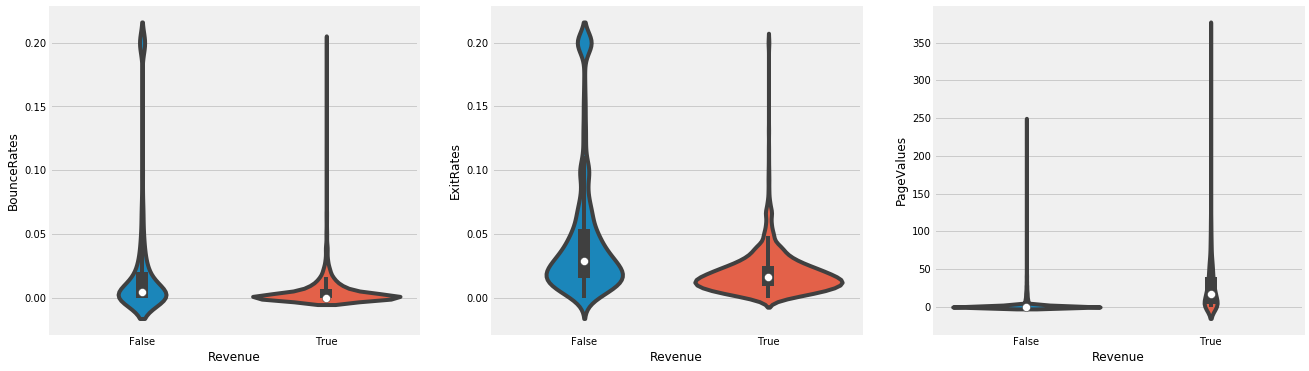

In [6]:
plt.clf()
fig, axs = plt.subplots(1,3,figsize=(20,6))

sns.violinplot(y= 'BounceRates',x= 'Revenue',ax=axs[0],data=df_shopping_data)
sns.violinplot(y= 'ExitRates',x= 'Revenue',ax=axs[1],data=df_shopping_data,showfliers=False)
sns.violinplot(y= 'PageValues',x= 'Revenue',ax=axs[2],data=df_shopping_data,showfliers=False)

#df_shopping_data.loc[:,['BounceRates','ExitRates','PageValues']].describe()

### Explore time related features
- SpecialDay: represents the closeness of the browsing date to special days
- Weekend: A boolean representing whether the session is on a weekend.
- Month: Contains the month the pageview occurred, in string form.
- We notice not all 12 months are present. Missing (Jan,Apr). Hence we will exlude it

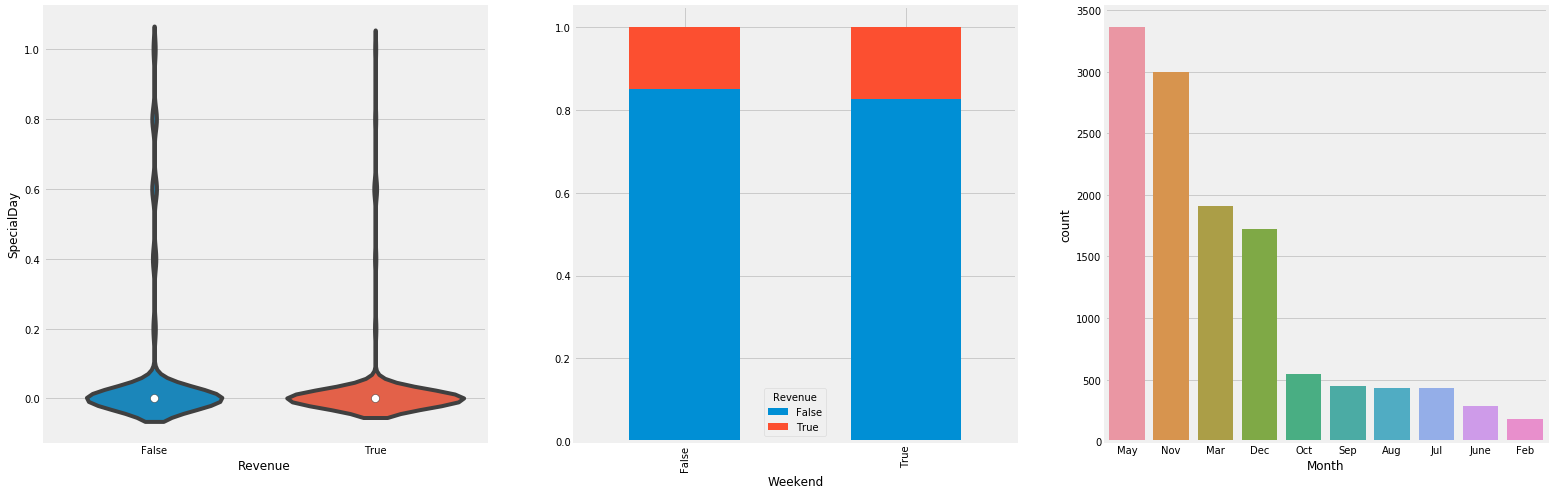

In [7]:
fig, axs = plt.subplots(1,3,figsize=(24,8))
sns.violinplot(y= 'SpecialDay',x= 'Revenue',ax=axs[0],data=df_shopping_data)

table=pd.crosstab(df_shopping_data.Weekend,df_shopping_data['Revenue'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax=axs[1])


monthly = df_shopping_data['Month'].value_counts()

sns.countplot(df_shopping_data['Month'], order=monthly.index,ax=axs[2])


### Explore Visitor attributes
- VisitorType:
- TrafficType: Type of traffic the user is categorized into. (i.e seo,direct etc) will be treated as a categorical feature
- Region: We will assume that the current exercise is not focusing on region

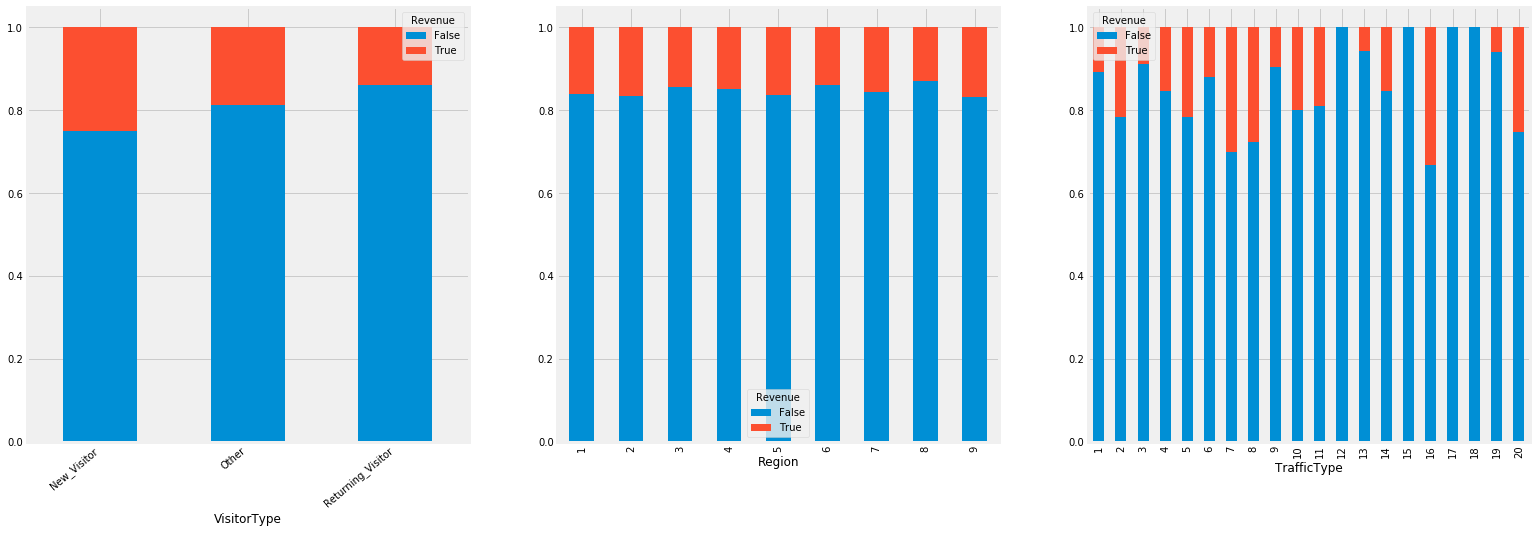

In [8]:
fig, axs = plt.subplots(1,3,figsize=(24,8))
table=pd.crosstab(df_shopping_data.VisitorType,df_shopping_data['Revenue'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=40, ha="right")
table=pd.crosstab(df_shopping_data.Region,df_shopping_data['Revenue'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax=axs[1])

table=pd.crosstab(df_shopping_data.TrafficType,df_shopping_data['Revenue'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,ax=axs[2])

## Drop following features
- OperatingSystems           
- Browser       
**We dont have much control over it. Large number of users are using a particular type of Browser or OS**

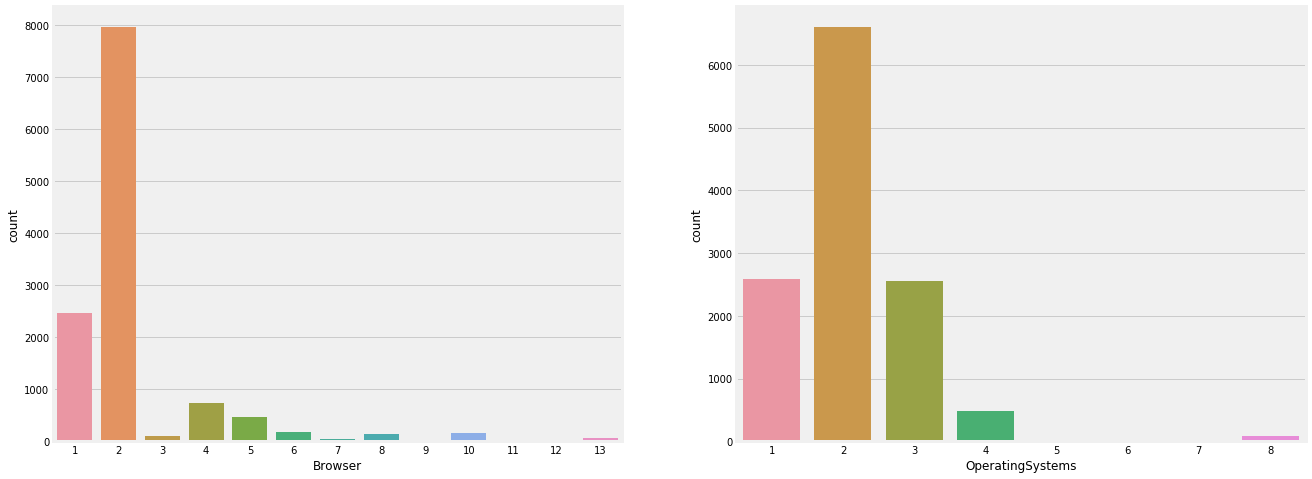

In [9]:
fig, axs = plt.subplots(1,2,figsize=(20,8))
sns.countplot(df_shopping_data['Browser'],ax=axs[0])
sns.countplot(df_shopping_data['OperatingSystems'],ax=axs[1])

## Feature Engineering
We will be using the following features
- Web session related features
    1. Administrative_normalized
    2. Informational_normalized
    3. ProductRelated_normalized
- digital metrics
    4. BounceRates
    5. ExitRates
- time related features
    6. SpecialDay
    7. Weekend (Categorical)
    
- Visitor attributes
    8.VisitorType
    9.TrafficType